In [1]:
import multiprocessing
import random
import collections
import time
import math
import pandas
import matplotlib.pyplot

In [2]:
%matplotlib inline

In [3]:
manager = multiprocessing.Manager()
key_queue = multiprocessing.Queue()
key_to_result = manager.dict()
procs = []

In [4]:
def f_basic(left_index, right_index, prices):
    """
    Maximize the profit.
    profit = prices[sell_index] - prices[buy_index]
    max(profit)

    Parameters
    ----------
    ?
    
    Returns
    -------
    low_index : int
    low : float
    high_index : int
    high : float
    buy_index : int
    sell_index : int
    max_gain : float
    """
    low_index = None
    low = None
    high_index = None
    high = None
    buy_index = 0
    sell_index = 0
    max_gain = 0
    if right_index - left_index <= 0:
        result = (low_index, low, high_index, high, buy_index, sell_index, max_gain)
        return result

    low_index = left_index
    low = prices[left_index]
    high_index = left_index
    high = prices[left_index]
    buy_index = left_index
    sell_index = left_index
    for index in range(left_index, right_index+1):
        price = prices[index]
        if price < low:
            low_index = index
            low = price
        if price > high:
            high_index = index
            high = price
        gain = price - low
        if gain > max_gain:
            sell_index = index
            buy_index = low_index
            max_gain = gain

    result = (low_index, low, high_index, high, buy_index, sell_index, max_gain)
    return result

In [5]:
def f(left_index, right_index, prices, l_r_chain):
    """
    Maximize the profit.
    profit = prices[sell_index] - prices[buy_index]
    max(profit)

    Parameters
    ----------
    left_index : int
    right_index : int
    prices : List[float]
    l_r_chain : tuple
        'L' or 'R', or None.

    Returns
    -------
    result : tuple
        low_index : int
        low : float
        high_index : int
        high : float
        buy_index : int
        sell_index : int
        max_gain : float
    """
    low_index = None
    low = None
    high_index = None
    high = None
    buy_index = 0
    sell_index = 0
    max_gain = 0
    if right_index - left_index <= 0:
        return low_index, low, high_index, high, buy_index, sell_index, max_gain

    low_index = left_index
    low = prices[left_index]
    high_index = left_index
    high = prices[left_index]
    buy_index = left_index
    sell_index = left_index
    for index in range(left_index, right_index+1):
        price = prices[index]
        if price < low:
            low_index = index
            low = price
        if price > high:
            high_index = index
            high = price
        gain = price - low
        if gain > max_gain:
            sell_index = index
            buy_index = low_index
            max_gain = gain

    key = (left_index, right_index, tuple(l_r_chain))
    result = (low_index, low, high_index, high, buy_index, sell_index, max_gain)
    key_queue.put(key)
    key_to_result[key] = result

In [6]:
def combine():
    while not key_queue.empty():
        key = key_queue.get()
        if key not in key_to_result.keys():
            continue
        
        left_index, right_index, l_r_chain = key
        result = key_to_result.pop(key)
        if len(l_r_chain) == 0:
            return result

        left_or_right = l_r_chain[-1]
        
        other_keys = key_to_result.keys()
        if left_or_right == 'L':
            other_keys = \
                [i for i in other_keys
                 if i[0] == right_index + 1]
        elif left_or_right == 'R':
            other_keys = \
                [i for i in other_keys
                 if i[1] == left_index - 1]

        if len(other_keys) == 1:
            other_key = other_keys[0]
            other_left_index, other_right_index, other_l_r_chain = other_key
            other_result = key_to_result.pop(other_key)
            if left_or_right == 'L':
                right_index = other_right_index
                result = _combine(result, other_result)
            elif left_or_right == 'R':
                left_index = other_left_index
                result = _combine(other_result, result)
        
        key = (left_index, right_index, l_r_chain[:-1])
        key_queue.put(key)
        key_to_result[key] = result

In [7]:
def _combine(result_1, result_2):
    """
    Parameters
    ----------
    result_1 : tuple
        This needs to be the left-side result.
    result_2 : tuple
        This needs to be the right-side result.

    Returns
    -------
    result : tuple
        low_index : int
        low : float
        high_index : int
        high : float
        buy_index : int
        sell_index : int
        max_gain : float
    """
    low_index_1, low_1, \
        high_index_1, high_1, \
        buy_index_1, sell_index_1, max_gain_1 = result_1
    low_index_2, low_2, \
        high_index_2, high_2, \
        buy_index_2, sell_index_2, max_gain_2 = result_2

    if low_1 < low_2:
        low_index = low_index_1
        low = low_1
    else:
        low_index = low_index_2
        low = low_2

    if high_1 > high_2:
        high_index = high_index_1
        high = high_1
    else:
        high_index = high_index_2
        high = high_2

    if max_gain_1 > max_gain_2:
        buy_index = buy_index_1
        sell_index = sell_index_1
        max_gain = max_gain_1
    else:
        buy_index = buy_index_2
        sell_index = sell_index_2
        max_gain = max_gain_2

    if (high_2 - low_1) > max_gain:
        buy_index = low_index_1
        sell_index = high_index_2
        max_gain = high_2 - low_1

    if max_gain == 0:
        buy_index = 0
        sell_index = 0

    result = (low_index, low, high_index, high, buy_index, sell_index, max_gain)
    return result

In [8]:
def _f2(left_index, right_index, prices, l_r_chain=None):
    """
    Parameters
    ----------
    ?
    prices : List[float]
    l_r_chain : str
        'L' or 'R', or None.

    Returns
    -------
    result : Tuple
        low_index, low, high_index, high, buy_index, sell_index, max_gain
    """
    if l_r_chain is None:
        l_r_chain = tuple()

    threshold = length//multiprocessing.cpu_count()
    curr_length = (right_index - left_index) + 1
    if curr_length > threshold:
        split = curr_length//2
        left_index_1 = left_index
        right_index_1 = left_index_1 + split
        left_index_2 = right_index_1 + 1
        right_index_2 = right_index
        _f2(left_index_1, right_index_1, prices, l_r_chain + ('L',))
        _f2(left_index_2, right_index_2, prices, l_r_chain + ('R',))
    else:
        proc = multiprocessing.Process(target=f, args=(left_index, right_index, prices, l_r_chain))
        procs.append(proc)
        proc.start()

In [9]:
def f2(prices):
    left_index = 0
    right_index = len(prices) - 1

    _f2(left_index, right_index, prices)    
    for proc in procs:
        proc.join()

    result = combine()
    return result

In [10]:
lengths = [10000, 100000, 1000000, 10000000, 20000000, 50000000]

In [11]:
def generate_prices(length):
    prices = range(length)
    random.shuffle(prices)
    return prices

In [12]:
def run_f_basic(prices):
    start_time = time.time()
    low_index, low, high_index, high, buy_index, sell_index, max_gain = f_basic(0, len(prices)-1, prices)
    end_time = time.time()
    time_elapsed = end_time - start_time
    return buy_index, sell_index, time_elapsed

In [13]:
def run_f2(prices):
    global key_queue, key_to_result, procs
    key_queue = multiprocessing.Queue()
    key_to_result = manager.dict()
    procs = []

    start_time = time.time()
    low_index, low, high_index, high, buy_index, sell_index, max_gain = f2(prices)
    end_time = time.time()
    time_elapsed = end_time - start_time
    return buy_index, sell_index, time_elapsed

In [14]:
times_elapsed = []
for length in lengths:
    prices = generate_prices(length)
    
    result_1 = run_f_basic(prices)
    print(result_1)
    result_2 = run_f2(prices)
    print(result_2)
    
    assert result_1[:2] == result_2[:2]
    times_elapsed.append((result_1[-1], result_2[-1]))
    print('\n')

(3242, 8914, 0.00510096549987793)
(3242, 8914, 0.060827016830444336)


(31069, 64586, 0.040472984313964844)
(31069, 64586, 0.07684111595153809)


(13491, 842000, 0.4700310230255127)
(13491, 842000, 0.3188149929046631)


(2293762, 2736499, 5.276416778564453)
(2293762, 2736499, 2.8951311111450195)


(10830186, 16112050, 12.848865985870361)
(10830186, 16112050, 7.491134881973267)


(2965145, 19882293, 32.122589111328125)
(2965145, 19882293, 20.83732509613037)




In [15]:
times_elapsed = pandas.DataFrame(times_elapsed, columns=['time_elapsed_1', 'time_elapsed_2'])

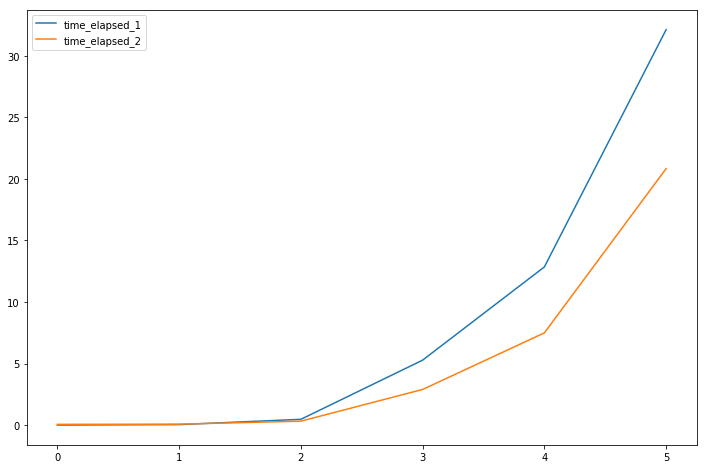

In [16]:
times_elapsed.plot(figsize=(12, 8))